In [1]:
import io
import tkinter as tk
from flask import Flask, render_template, request, redirect, url_for
from tkinter import filedialog
from tkinter import messagebox
from PIL import Image, ImageTk
from IPython.display import display,clear_output
from ipywidgets import widgets

import matplotlib.pyplot as plt
import pickle
import numpy as np
import os
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input #extracting features from pictures
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer

from tensorflow.keras.preprocessing.sequence import pad_sequences #to even out text
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add #importing the layers

app = Flask(__name__)
UPLOAD_FOLDER = 'uploads'
app.config['UPLOAD_FOLDER'] = UPLOAD_FOLDER

if not os.path.exists(UPLOAD_FOLDER):
    os.makedirs(UPLOAD_FOLDER)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:


base_dir = "/content/drive/MyDrive/image_captioning/BASEdir"
working_dir ="/content/drive/MyDrive/image_captioning/workingdir"


#lets load the model

model = VGG16()

#restructure the model

model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

#summerize

print(model.summary())

553467096/553467096 [==============================] - 19s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

In [4]:
#extract features from the image

features = {}

directory = os.path.join(base_dir,"Images")

for img_name in tqdm(os.listdir(directory)):
  #getting images from file one-by-one
  img_path = os.path.join(directory,img_name)
  image = load_img(img_path, target_size = (224,224))

  #converting image pixels to numpy array
  image = img_to_array(image)

  #reshape data to model
  image = image.reshape((1,image.shape[0], image.shape[1], image.shape[2]))

  #preprocess the iamge to vgg16

  image = preprocess_input(image)

  #extract the features

  feature = model.predict(image, verbose = 0)

  #getting the image id

  image_id = img_name.split('.')[0]  #removing image from its extension

  #storing the feature

  features[image_id] = feature

  0%|          | 0/8092 [00:00<?, ?it/s]

In [5]:
#storing the features so we dont want to extarct it again

pickle.dump(features, open(os.path.join(working_dir, 'features.pkl'), 'wb'))

In [6]:
#now lets get the features from the pickle

with open(os.path.join(working_dir, 'features.pkl'),'rb') as f:
  features = pickle.load(f)

In [7]:
#now lets load the captions

with open(os.path.join(base_dir, 'captions.txt'), 'r') as f:
  next(f)
  captions_doc = f.read()

In [8]:
type(captions_doc)

str

In [9]:
#now lets map the captions to the respective image

mapping = {}

for line in tqdm(captions_doc.split('\n')):
  #now lets split each line the the comma(since in the txt file the image name and the discription is sep by a comma)
  tokens = line.split(',')
  if len(line) < 2:
    continue
  image_id, caption = tokens[0], tokens[1:]

  #removing the extension from the image name to get the image id
  image_id = image_id.split('.')[0]

  #now lets convert caption list to string
  caption = " ".join(caption)

  #if one image has 2 captions put the cations to a list

  if image_id not in mapping:
    mapping[image_id] = []
  #lets store the caption
  mapping[image_id].append(caption)

  0%|          | 0/40460 [00:00<?, ?it/s]

In [12]:
def clean(mapping):
  for key, captions in mapping.items():
    for i in range(len(captions)):
      caption = captions[i].lower()
      caption = re.sub('[^a-z]', ' ', caption)
      caption = re.sub('\s+', ' ', caption)
      caption = 'startseq ' + ' '.join([word for word in caption.split() if len(word) > 1 ]) + ' endseq'
      captions[i] = caption

In [13]:
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [11]:
import re
#preprocess the text
clean(mapping)

In [14]:
all_captions = []
for key in mapping:
  for caption in mapping[key]:
    all_captions.append(caption)

In [15]:
#lets tokenize the text

tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [16]:
#lets get the maximium of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

In [17]:
image_ids = list(mapping.keys())
split = int(len(image_ids)*0.90)
train = image_ids[:split]
test = image_ids[split:]

In [18]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = list(), list(), list()
                n = 0

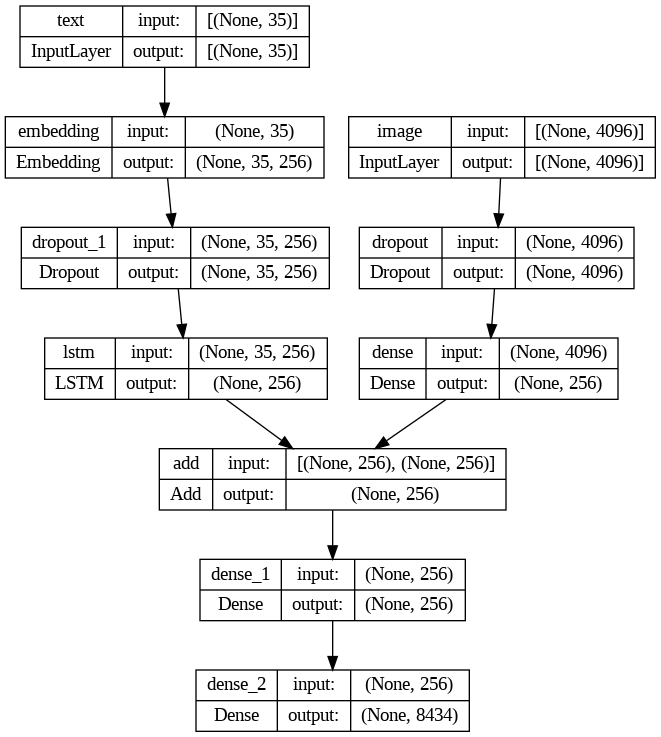

In [19]:
# Define the model with explicit input names
inputs1 = Input(shape=(4096,), name="image")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# Decoder model
decoder_1 = add([fe2, se3])
decoder_2 = Dense(256, activation='relu')(decoder_1)
outputs = Dense(vocab_size, activation='softmax')(decoder_2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Plot the model
plot_model(model, show_shapes=True)

In [20]:
type(mapping)


dict

In [21]:
# Train the model
epochs = 15
batch_size = 64
steps = len(train) // batch_size

train_loss =[]
train_accuracy=[]

for i in range(epochs):
    # Create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # Fit for one epoch
    history = model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
      # Store loss and accuracy
    train_loss.append(history.history['loss'][0])
    train_accuracy.append(history.history['accuracy'][0])


113/113 [==============================] - 56s 497ms/step - loss: 2.4814 - accuracy: 0.3999


In [22]:
#save the model
model.save(working_dir+'best_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


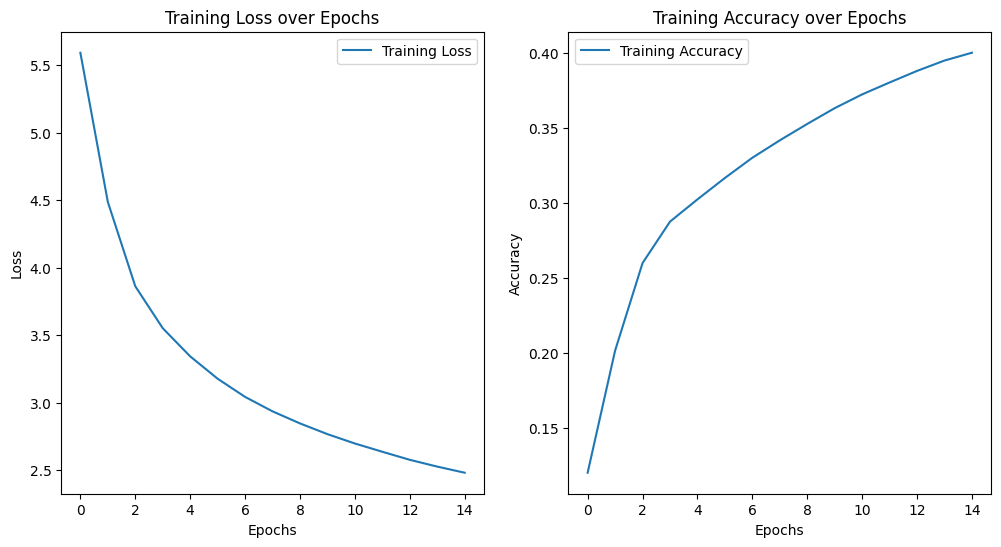

In [23]:
# Plot training loss and accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_loss, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_accuracy, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy over Epochs')
plt.legend()

plt.show()

In [24]:
def idx_to_world(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [25]:
#generates caption for an image
def predict_caption(model, image, tokenizer, max_lenght):
    #add start tag for generation process
    in_text = 'startseq'
    #iterate over the max lenght of sequence
    for i in range(max_lenght):
        #encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        #pad the sequence
        sequence = pad_sequences([sequence], max_lenght)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        #get index with high probability
        yhat  = np.argmax(yhat)
        #convert index to word
        word = idx_to_world(yhat, tokenizer)
        #stop of word not found
        if word is None:
            break


        #append word as input for generating next word
        in_text += " " + word
        #stop if we reach end tag
        if word == 'endseq':

            break

    return in_text


In [28]:
from nltk.translate.bleu_score import corpus_bleu
#validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    #get actual caption
    captions = mapping[key]
    #predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    #split into words

    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()

    #append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)

 #calculate BLEU score
print("BLEU-1: %f"  %corpus_bleu(actual, predicted, weights = (1.0,0,0,0)))
print("BLEU-2: %f"  %corpus_bleu(actual, predicted, weights = (1.0,0,0,0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.548563
BLEU-2: 0.548563


In [26]:
## Visualize the Results

from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # Load the image
    image_id = image_name.split('.')[0]
    img_path = os.path.join(base_dir, "Images", image_name)
    image = Image.open(img_path)

    # Fetch the actual captions
    captions = mapping[image_id]
    print('-------------------Actual-------------------')
    for caption in captions:
        print(caption)

    # Predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('-------------------Predicted-------------------')
    print(y_pred)

    # Display the image
    plt.imshow(image)
    plt.axis('off')  # Hide axes
    plt.show()



-------------------Actual-------------------
startseq man sits on rock endseq
startseq man sitting on cliff in the mountains endseq
startseq man wearing blue shirt crouches on rocky cliff endseq
startseq person posing on mountaintop endseq
startseq the man is sitting at the top of rocky mountain endseq
-------------------Predicted-------------------
startseq man sits on rocky mountain endseq


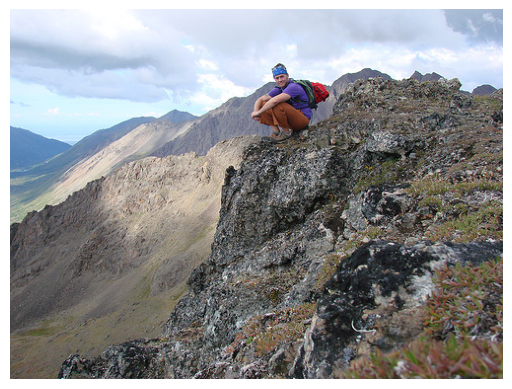

In [32]:
generate_caption("1247181182_35cabd76f3.jpg")

In [33]:
vgg_model = VGG16()
vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)

startseq man hikes on rocky mountain endseq


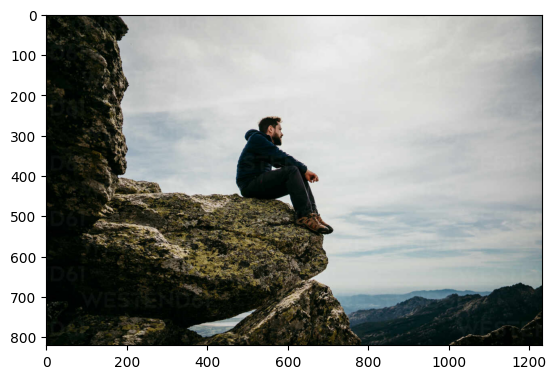

In [43]:
from PIL import Image
import matplotlib.pyplot as plt


image_path ="/content/drive/MyDrive/image_captioning/side-view-of-man-sitting-on-the-edge-of-on-stone-admiring-puerto-de-la-morcuera-mountain-range-on-cloudy-day-in-spain-ADSF17302.jpg"
image = load_img(image_path, target_size=(224, 224))
image = img_to_array(image)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
image = preprocess_input(image)
features = vgg_model.predict(image, verbose=0)
predict_caption(model, features, tokenizer, max_length)
image2 = Image.open(image_path)
plt.imshow(image2)
print(predict_caption(model, features, tokenizer, max_length))
